1. 데이터셋 불러오기 및 feature 분석(1번, 2-1번 문제)

In [1]:
import pandas as pd

df = pd.read_csv("netflix_reviews.csv")  # 파일 불러오기
print(f"Shape of the dataset: {df.shape}")  # 데이터 크기 출력(행, 열 수) 
# 117,134개의 행이 있고, 8개의 열이 있다.
print(f"Columns in the dataset: {df.columns}")  # 데이터 열 이름 출력
#열의 이름은 식별자, 닉네임, 내용, 평점, 좋아요 수, 앱버전, 날짜 및 시간, 버전 정보로 확인된다.

Shape of the dataset: (117134, 8)
Columns in the dataset: Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')


In [2]:
# 전처리 함수
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 대문자를 소문자로
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = text.strip()  # 띄어쓰기 제외하고 빈 칸 제거
    return text

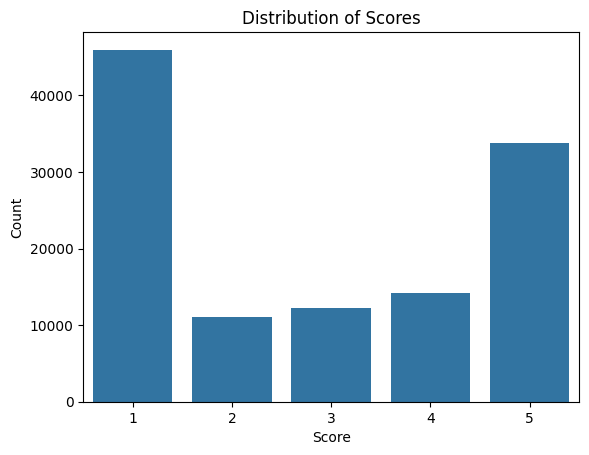

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt  # 라이브러리 임포트

score_counts = df['score'].value_counts().reset_index()  #score열에 들어 있는 점수들의 빈도를 계산함
score_counts.columns = ['score', 'count']  # 열이름을 리뷰점수score와 리뷰개수count로 지정함

# 계산된 'score'와 'count'를 이용해 막대 그래프 생성
sns.barplot(x=score_counts['score'], y=score_counts['count'])  #seaborn의 막대 그래프를 생성함(x축은 점수, y축은 개수)
plt.xlabel('Score')  #x축 레이블 제목지정
plt.ylabel('Count')  #y축 레이블 제목지정
plt.title('Distribution of Scores')  #그래프 제목지정
plt.show()  # 그래프표시

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder

# 데이터셋 클래스 정의: 리뷰와 점수를 관리하는 클래스
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):  # init 데이터 초기화
        self.reviews = reviews  # 리뷰 데이터
        self.ratings = ratings  # 리뷰에 대응되는 점수 데이터
        self.text_pipeline = text_pipeline  # 텍스트 데이터를 숫자로 변환하는 함수
        self.label_pipeline = label_pipeline  # 레이블 데이터를 숫자로 변환하는 함수

    def __len__(self):  # 길이 반환
        return len(self.reviews)  # 전체 크기 반환

    def __getitem__(self, idx):  #  주어진 인덱스에 해당하는 리뷰와 점수를 변환해 반환
        review = self.text_pipeline(self.reviews[idx])  # 리뷰를 숫자로 변환
        rating = self.label_pipeline(self.ratings[idx])  # 점수(레이블)를 숫자로 변환
        return torch.tensor(review), torch.tensor(rating)  # 숫자로 변환된 리뷰와 점수를 텐서로 반환

# 예시 데이터 정의: 학습 및 테스트용 리뷰와 점수
train_reviews = ["This app is amazing", "I don't like the design", "It's a good app", "Terrible experience"]
train_ratings = [5, 1, 4, 2]  # 각 리뷰에 대한 점수
test_reviews = ["I love it", "Not great"]
test_ratings = [5, 3]  # 테스트용 리뷰와 점수

# 텍스트 파이프라인 정의  # 소문자로 변환하고 공백을 기준으로 나눔
def simple_tokenizer(text):  
    return text.lower().split()  

vocab = {}  # 간단한 단어 사전 생성  # 고유한 인덱스로 변환
for review in train_reviews + test_reviews:  # 학습과 테스트 리뷰를 모두 사용해 사전 구성
    for token in simple_tokenizer(review):  # 리뷰의 단어를 토큰으로 분리
        if token not in vocab:  # 단어가 사전에 없으면
            vocab[token] = len(vocab)  # 새로운 인덱스를 할당

def text_pipeline(text):  # 텍스트를 숫자 인덱스로 변환
    return [vocab[token] for token in simple_tokenizer(text) if token in vocab]

label_encoder = LabelEncoder()  # 점수를 숫자로 변환
label_encoder.fit(train_ratings)  # 점수를 사용해 인코딩
label_pipeline = lambda x: label_encoder.transform([x])[0]  # 레이블을 숫자로 변환하는 람다 함수

# collate_fn: 패딩을 추가해 리뷰길이를 일정하게 맞춤
def collate_fn(batch):
    reviews, ratings = zip(*batch)  # 리뷰와 점수를 나눠서 그룹화
    reviews_padded = pad_sequence(reviews, batch_first=True, padding_value=0)  # 리뷰길이가 달라 0으로 패딩
    ratings = torch.stack(ratings)  # 레이블을 스택으로 쌓음
    return reviews_padded, ratings  # 패딩된 리뷰와 레이블 반환

# 데이터셋 정의: 학습용, 테스트용
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)

# 데이터 로더는 배치 크기만큼 데이터를 불러옴  
BATCH_SIZE = 2  # 배치크기정의
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)  # 학습용 데이터 로더
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)  # 테스트용 데이터 로더

# LSTM 모델 정의: 리뷰를 학습하고 점수를 예측함
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding: 단어를 고정된 크기의 벡터로 변환
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)  # lstm: 시퀀스 데이터를 처리해 시간적 관계를 학습
        self.fc = nn.Linear(hidden_dim, output_dim)  # fc: lstm의 마지막 숨겨진 상태를 받아 예측 결과를 출력

    def forward(self, text):
        embedded = self.embedding(text)  # 텍스트 임베딩(벡터화)
        lstm_out, (hidden, cell) = self.lstm(embedded)  # 시퀀스 처리
        return self.fc(hidden[-1])  # 점수 예측

# 하이퍼파라미터 설정
VOCAB_SIZE = len(vocab)  # 사전크기(단어 수)
EMBED_DIM = 64  # 임베딩 벡터 차원 수
HIDDEN_DIM = 128  # lstm의 숨겨진 상태 차원
OUTPUT_DIM = len(set(train_ratings))  # 예측할 점수(레이블) 개수

# lstm모델 초기화 
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM) 

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류를 위한 교차 엔트로피 손실 함수
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 확률적 경사하강법(SDG)을 사용한 옵티마이저(학습률 0.01)

# 모델 학습 함수
def train_model(model, dataloader, criterion, optimizer, epochs=5):
    model.train()  #  모델 학습모드설정
    for epoch in range(epochs):  # 지정 epoch만큼 반복학습
        total_loss = 0  # epoch동안의 총 손실값 초기화
        for reviews, ratings in dataloader:  # 배치단위로 데이터 로드
            optimizer.zero_grad()  # 이전 기울기 초기화
            output = model(reviews)  # 모델에 리뷰데이터 입력하여 예측 값 출력
            loss = criterion(output, ratings)  # 예측 값과 실제 레이블 간의 손실 계산
            loss.backward()  # 손실을 기준으로 기울기를 계산(역전파)
            optimizer.step()  # 기울기를 사용해 모델의 가중치 업데이트
            total_loss += loss.item()  # 손실 값 누적
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}')  # 에포크별 손실 출력

train_model(model, train_dataloader, criterion, optimizer)  # 모델 학습 실행

# 예측 함수: 새로운 리뷰에 대해 예측된 점수 반환
def predict_review(model, review):  
    model.eval()  # 모델을 평가 모드로 전환
    with torch.no_grad():  # 기울기 계산을 비활성화(평가 시 불필요)
        tensor_review = torch.tensor(text_pipeline(review), dtype=torch.long).unsqueeze(0)  
        # unsqueeze(0) 리뷰를 숫자로 변환한 후 배치 차원 추가
        output = model(tensor_review)  # 모델을 사용해 예측
        prediction = output.argmax(1).item()  # 예측한 클래스(점수) 선택
        return label_encoder.inverse_transform([prediction])[0]  # 예측된 숫자를 원래 점수로 변환

# 새로운 리뷰에 대한 예측
new_review = "This app is great but has some bugs."  # 새로운 리뷰 입력
predicted_score = predict_review(model, new_review)  # 새로운 리뷰에 대한 예측 수행
print(f'Predicted Score: {predicted_score}')  # 예측된 점수 출력

# 출력결과 loss값은 다섯 번의 epoch 동안 1.38에서 1.33으로 감소했으나 감소 폭이 크지 않았음 
# 이는 모델이 아직 최적화 되지 않았거나 더 많은 학습이 필요함을 의미함.
# "어플이 훌륭하지만 약간의 버그가 있다"는 새로운 리뷰에 대해 모델이 예측한 값은 1임
# 약간의 결점만 언급하였음에도 낮은 점수를 예측한 것은, 모델이 적절히 학습되지 않았음을 의미함.
# 따라서 더 많은 학습과 데이터셋의 크기를 조정함으로써 성능을 개선할 필요가 있음.

Epoch 1/5, Loss: 1.3810
Epoch 2/5, Loss: 1.3585
Epoch 3/5, Loss: 1.3571
Epoch 4/5, Loss: 1.3385
Epoch 5/5, Loss: 1.3337
Predicted Score: 1
